# 2026 QMW - Genomics Module

January 5, 2026

Author: Erik Owen | Graduate Student in Computational & Systems Biology | Page Lab

# Goals:

- QC summary from FASTQ
- Alignment (BAM) & index
- Coverage & MAPQ summaries
- Variant calls (VCF)
- Comparison to ground truth VCF

# Environment Setup

- download software tools + packages that we'll use in this tutorial
- download toy data

### What does `!` mean?

In Colab/Jupyter, you'll see lines that start with an exclamation mark, like `!ls` or `!bowtie2 --version`.

`!` tells the notebook: “run the rest of this line as a shell command (like you typed it in a Terminal), not as Python.”

- `!ls` lists files in the current folder
- `!pwd` prints the current folder path
- `!curl ...` is a command-line tool for data transfer
- `!zcat file.fastq.gz | head` runs a small pipeline of command-line tools
  - `|` is called a "pipe". This sends the output of the command on the left directly into the command on the right so you can "stream" results without creating intermediate files.

*Important*: `!` only works inside notebook cells. If you copy the same line into a .sh bash script, you must remove the `!` (because scripts are already “shell mode”).

In [1]:
!curl -L https://raw.githubusercontent.com/erik-owen/2026_QMW_Genomics/main/scripts/bootstrap_colab.sh | bash


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1159  100  1159    0     0   5440      0 --:--:-- --:--:-- --:--:--  5441
> Installing tools...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libhtscodecs2:amd64.
(Reading database ... 117528 files and directories currently installed.)
Preparing to unpack .../0-libhtscodecs2_1.1.1-3_amd64.deb ...
Unpacking libhtscodecs2:amd64 (1.1.1-3) ...
Selecting previously unselected package libhts3:amd64.
Preparing to unpack .../1-libhts3_1.13+ds-2build1_amd64.deb ...
Unpacking libhts3:amd64 (1.13+ds-2build1) ...
Selecting previously unselected package bcftools.
Preparing to unpack .../2-bcftools_1.13-1_amd64.deb ...
Unpacking bcftools (1.13-1) ...
Selecting

The `tree` command is a UNIX command-line utility that shows your directory + file structure.

We'll be using it throughout the notebook to show you what files we're creating + using!

In [5]:
!tree

.
├── data
│   └── loci
│       ├── locus1_HBB.ind1_noHbS.reads_R1.fastq.gz
│       ├── locus1_HBB.ind2_HbS_carrier.reads_R1.fastq.gz
│       ├── locus1_hg38_chr11_5215464_5237071_HBB.fa
│       ├── locus1_hg38_chr11_5215464_5237071_HBB.repeats.local.bed
│       ├── locus2_hg38_chr8_96243643_96263643_MTERF3.fa
│       ├── locus2_hg38_chr8_96243643_96263643_MTERF3.repeats.local.bed
│       └── locus2_MTERF3_repeat.ind1_repeat_mix.reads_R1.fastq.gz
├── sample_data
│   ├── anscombe.json
│   ├── california_housing_test.csv
│   ├── california_housing_train.csv
│   ├── mnist_test.csv
│   ├── mnist_train_small.csv
│   └── README.md
└── work
    └── case1_ind1_noHbS

5 directories, 13 files


In [11]:
#@title Select case study inputs
CASE = 1  #@param {type:"integer", min:1, max:2}
SAMPLE = "ind1_noHbS"  #@param ["ind1_noHbS", "ind2_HbS_carrier", "ind1_repeat_mix"]

from pathlib import Path

DATA = Path("data") / "loci"
assert DATA.exists(), f"Missing {DATA}. Did the bootstrap step run?"

FILES = {
    (1, "ind1_noHbS"): dict(
        ref=DATA / "locus1_hg38_chr11_5215464_5237071_HBB.fa",
        reads=DATA / "locus1_HBB.ind1_noHbS.reads_R1.fastq.gz",
        repeats=DATA / "locus1_hg38_chr11_5215464_5237071_HBB.repeats.local.bed",
    ),
    (1, "ind2_HbS_carrier"): dict(
        ref=DATA / "locus1_hg38_chr11_5215464_5237071_HBB.fa",
        reads=DATA / "locus1_HBB.ind2_HbS_carrier.reads_R1.fastq.gz",
        repeats=DATA / "locus1_hg38_chr11_5215464_5237071_HBB.repeats.local.bed",
    ),
    (2, "ind1_repeat_mix"): dict(
        ref=DATA / "locus2_hg38_chr8_96243643_96263643_MTERF3.fa",
        reads=DATA / "locus2_MTERF3_repeat.ind1_repeat_mix.reads_R1.fastq.gz",
        repeats=DATA / "locus2_hg38_chr8_96243643_96263643_MTERF3.repeats.local.bed",
    ),
}

paths = FILES[(CASE, SAMPLE)]
for k, p in paths.items():
    assert p.exists(), f"Missing {k}: {p}"
paths


{'ref': PosixPath('data/loci/locus1_hg38_chr11_5215464_5237071_HBB.fa'),
 'reads': PosixPath('data/loci/locus1_HBB.ind1_noHbS.reads_R1.fastq.gz'),
 'repeats': PosixPath('data/loci/locus1_hg38_chr11_5215464_5237071_HBB.repeats.local.bed')}

# Sequencing & File formats

## Inpsect a FASTA file

FASTA files is a text-based format for representing a sequence.

It has two parts:
- header: begins with `>`, + single line description of sequence
- sequence representation: 1 letter per nucleic acid

You've been provided 2 FASTA files. Go ahead and inpsect them using the command line:

- locus1_hg38_chr11_5215464_5237071_HBB.fa
- locus2_hg38_chr8_96243643_96263643_MTERF3.fa

In [3]:
!echo "FASTA heads:"
!echo
!head -n 3 data/loci/locus1_hg38_chr11_5215464_5237071_HBB.fa
!echo
!head -n 3 data/loci/locus2_hg38_chr8_96243643_96263643_MTERF3.fa


FASTA heads:

>locus1_hg38_chr11_5215464_5237071_HBB
GAAATCCTGGGCTCAAGTGATCCTATCACTTCAGCCTCCTGGGTTACTGGGACTACAGAT
GCAAGCCACTGTGCCCAGCTTGGCTCTTTCTTTTTATTTTAATTGGTCACTTTGTTTTCA

>locus2_hg38_chr8_96243643_96263643_MTERF3
TTTAAGGGAAGTGATCTATTCCAAAGTAAAGTAGAGAAAAACATGAGAGAGAAGAGAGAC
TACATTAGATTTGTTGGCCTGATTCCAACAATCAGAACTAGGACTAGGTAGAAACTCCAG


Now, using `python`, inspect our first case study. Return:
- FASTA header
- sequence length
- GC% content
- first 80 base pairs

Note: we've stored the paths to our data in: the paths dict. You want to select the `*.fa` file under `paths["ref"]`

In [16]:
import re # package for regular expressions

def read_fasta_one(path):
    header = None
    seq_chunks = []
    with open(path, "rt") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith(">"):
                header = line[1:]
            else:
                seq_chunks.append(line)
    if header is None:
        raise ValueError(f"No FASTA header found in {path}")
    seq = "".join(seq_chunks).upper()
    return header, seq

def gc_fraction(seq: str) -> float:
    gc = sum(1 for b in seq if b in ("G","C"))
    atgc = sum(1 for b in seq if b in ("A","T","G","C"))
    return (gc / atgc) if atgc else float("nan")

ref_path = paths["ref"]
header, ref_seq = read_fasta_one(ref_path)

print("FASTA:", ref_path.name)
print("Header:", header)
print("Length (bp):", len(ref_seq))
print("GC fraction:", round(gc_fraction(ref_seq), 4))
print("First 80 bp:", ref_seq[:80])

# Extract chr/start/end if present in header or filename
m = re.search(r"(chr[\w]+)[:_](\d+)[-_](\d+)", header) or re.search(r"(chr[\w]+)_(\d+)_(\d+)", ref_path.name)
if m:
    chrom, start, end = m.group(1), int(m.group(2)), int(m.group(3))
    print("Parsed locus:", chrom, start, end, "(span:", end-start, "bp )")


FASTA: locus1_hg38_chr11_5215464_5237071_HBB.fa
Header: locus1_hg38_chr11_5215464_5237071_HBB
Length (bp): 21607
GC fraction: 0.3827
First 80 bp: GAAATCCTGGGCTCAAGTGATCCTATCACTTCAGCCTCCTGGGTTACTGGGACTACAGATGCAAGCCACTGTGCCCAGCT
Parsed locus: chr11 5215464 5237071 (span: 21607 bp )


Does this FASTA represent:
- the whole human genome?
- 1 chromosome?
- a small region?

Why would your above answer be appropriate for a class setting?

Answer in MITx

## Inspect a FASTQ file

What do reads look like?

Preview a few FASTQ records, then compute:

- number of reads
- read length
- quick quality summary + plot

In [20]:
import gzip
from statistics import mean

def fastq_iter_gz(path):
  opener = gzip.open if str(path).endswith(".gz") else open
  with opener(path, "rt") as f:
    while True:
      h = f.readline().rstrip()
      if not h:
        return
      s = f.readline().rstrip()
      plus = f.readline().rstrip()
      q = f.readline().rstrip()
      yield h, s, plus, q

def phred33_to_q(qual: str):
  '''
  Converts symbol to Q score
  '''
  return [ord(c) - 33 for c in qual]

reads_path = paths["reads"]

# Preview first 3 records
it = fastq_iter_gz(reads_path)
for i in range(3):
    h, s, plus, q = next(it)
    print("---- record", i+1, "----")
    print(h)
    print("seq (first 60):", s[:60], "...")
    print("qual(first 60):", q[:60], "...")
    print("len:", len(s), "meanQ:", round(mean(phred33_to_q(q)), 2))

# Stream stats
n_reads = 0
lengths = []
mean_qs = []

for h, s, plus, q in fastq_iter_gz(reads_path):
    n_reads += 1
    lengths.append(len(s))
    mean_qs.append(mean(phred33_to_q(q)))

---- record 1 ----
@ind1_noHbS_R1_1
seq (first 60): CAGTTCTGTGAAGAAAGTCATTGGTAGCTTGATGGGGATGGCATTGAATCTATAAATTAC ...
qual(first 60): DGDB?ECACCADCEBDGBEI>E;C;<??>@><?;?>;<C=>A:=B<<6;<=?9>:;57;8 ...
len: 100 meanQ: 26.85
---- record 2 ----
@ind1_noHbS_R1_2
seq (first 60): AGAAATCACCCGTCTTCTGCGTCACTCACGATGGGAGCTATAGACTGGAGCTGTTCCTAT ...
qual(first 60): G@BE=AC?DDAEDCA>@DBBB@C?ED>CB:=>BC?:=;C><@;@>79<=>;:<C<7>=;? ...
len: 100 meanQ: 26.82
---- record 3 ----
@ind1_noHbS_R1_3
seq (first 60): TATAAAAAATGGTGTGGGGGAGGGTTTGGAAAGATTTTTTGGGTAGTATAGAGAAGTTTA ...
qual(first 60): BBDFFGFFDEC?>F@AA@;;B?C>==9><B>>>@<CB9<>?B<<<8=9;=9;@??::839 ...
len: 100 meanQ: 26.42


In [22]:
# Teacher notebook: return all answers
print("\nFASTQ:", reads_path.name)
print("Reads:", n_reads)
print("Read length: min/mean/max =", min(lengths), round(mean(lengths), 2), max(lengths))
print("Mean Q (per-read): min/mean/max =", round(min(mean_qs),2), round(mean(mean_qs),2), round(max(mean_qs),2))



FASTQ: locus1_HBB.ind1_noHbS.reads_R1.fastq.gz
Reads: 2471
Read length: min/mean/max = 100 100 100
Mean Q (per-read): min/mean/max = 25.64 26.5 27.4


In [28]:
# Student notebook:
print("MITx checkpoint: submit the number of reads in this FASTQ.")
print("Sanity check: this is on the order of 10^3")


MITx checkpoint: submit the number of reads in this FASTQ.
Sanity check: this is on the order of 10^3


### Per-base quality profile

Now, we want to explore the quality of our reads which is given by our Phred quality scores:

$Q=-10\log_{10} P$

Where $P$ is the probability of an calling that base incorrectly!


In [27]:
import math

for Q in [10, 20, 30, 40]:
    p = 10 ** (-Q/10)
    print(f"Q={Q}: error probability ≈ {p:g} (≈ 1 in {round(1/p):,} bases)")


Q=10: error probability ≈ 0.1 (≈ 1 in 10 bases)
Q=20: error probability ≈ 0.01 (≈ 1 in 100 bases)
Q=30: error probability ≈ 0.001 (≈ 1 in 1,000 bases)
Q=40: error probability ≈ 0.0001 (≈ 1 in 10,000 bases)


In [29]:
# Student notebook:
print("MITx checkpoint: What is the mean Q per-read in our raw FASTQ file?")
print("Does this make you worry about the errors?")


MITx checkpoint: What is the mean Q in our raw FASTQ file?
Does this make you worry about the errors?


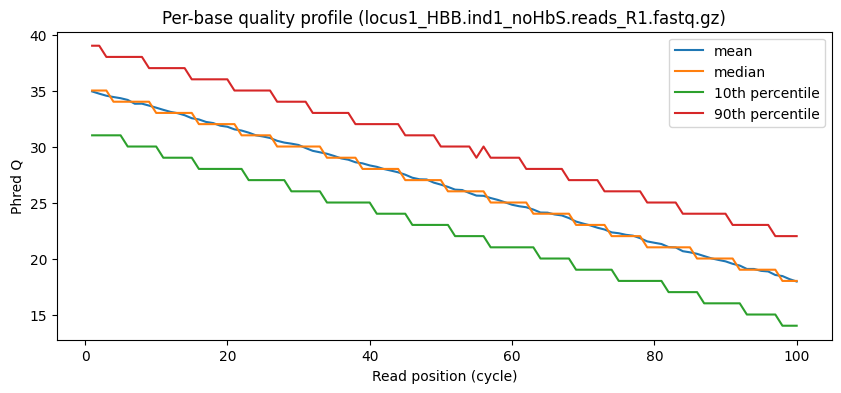

Reads processed: 2471
Mean Q by cycle: min/median/max = 17.95 26.5 34.92


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
import gzip

def fastq_iter_gz(path):
    opener = gzip.open if str(path).endswith(".gz") else open
    with opener(path, "rt") as f:
        while True:
            h = f.readline().rstrip()
            if not h:
                return
            s = f.readline().rstrip()
            plus = f.readline().rstrip()
            q = f.readline().rstrip()
            yield h, s, plus, q

def phred33_to_q(qual: str):
    return np.fromiter((ord(c) - 33 for c in qual), dtype=np.int16)

reads_path = paths["reads"]

# collect per-cycle Q scores
per_cycle = []  # list of lists
n = 0

for h, s, plus, qstr in fastq_iter_gz(reads_path):
    q = phred33_to_q(qstr)
    if not per_cycle:
        per_cycle = [[] for _ in range(len(q))]
    for i, qi in enumerate(q):
        per_cycle[i].append(int(qi))
    n += 1

per_cycle = [np.array(v, dtype=np.int16) for v in per_cycle]
mean_q = np.array([v.mean() for v in per_cycle], dtype=float)
p10 = np.array([np.percentile(v, 10) for v in per_cycle], dtype=float)
p50 = np.array([np.percentile(v, 50) for v in per_cycle], dtype=float)
p90 = np.array([np.percentile(v, 90) for v in per_cycle], dtype=float)

x = np.arange(1, len(per_cycle) + 1)

plt.figure(figsize=(10,4))
plt.plot(x, mean_q, label="mean")
plt.plot(x, p50, label="median")
plt.plot(x, p10, label="10th percentile")
plt.plot(x, p90, label="90th percentile")
plt.xlabel("Read position (cycle)")
plt.ylabel("Phred Q")
plt.title(f"Per-base quality profile ({reads_path.name})")
plt.legend()
plt.show()

print("Reads processed:", n)
print("Mean Q by cycle: min/median/max =", round(mean_q.min(),2), round(np.median(mean_q),2), round(mean_q.max(),2))
